In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import time
import pickle

from statsmodels.tsa.seasonal import MSTL
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.metrics import mean_pinball_loss

import data_prepro as data_prepro

In [54]:
from importlib import reload
reload(data_prepro)

<module 'data_prepro' from 'c:\\Users\\ytl_c\\OneDrive\\Desktop\\22 ECON Hiwi\\2023_11-Karlsruhe-Bicycle-Data\\data_prepro.py'>

### Get Data

In [3]:
# import csv file
df = pd.read_csv('./data/2012-04-25_to_2024-01-06_KA_bike_data.csv')

# change date col to datetime
df['date'] = pd.to_datetime(df['date'])
# set index as timestamp_CET but keep col
df.set_index('date', inplace=True, drop=False)
# rename date to timestamp_CET
df.rename(columns={'date': 'timestamp_CET'}, inplace=True)

print(df.info())
print(df.columns)
df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4261 entries, 2012-04-25 to 2024-01-06
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp_CET   4261 non-null   datetime64[ns]
 1   bike_count      4261 non-null   int64         
 2   temperature     4261 non-null   float64       
 3   humidity        4261 non-null   float64       
 4   windspeed       4261 non-null   float64       
 5   wind_direction  4261 non-null   float64       
 6   visibility      4261 non-null   float64       
 7   precipitation   4261 non-null   float64       
 8   sun             4261 non-null   int64         
 9   windspeed_max   4261 non-null   float64       
 10  precip_indic    4258 non-null   float64       
 11  precip_type     4076 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(2)
memory usage: 432.8 KB
None
Index(['timestamp_CET', 'bike_count', 'temperature', 'humidity', 'winds

,timestamp_CET,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type
date,,,,,,,,,,,,
2024-01-02,2024-01-02,1631,9.245833,83.916667,10.062500,218.333333,23492.916667,23.3,0,22.0,1.0,6.0
2024-01-03,2024-01-03,2553,10.466667,77.250000,9.245833,223.333333,57993.750000,11.5,24,18.8,1.0,6.0
2024-01-04,2024-01-04,3188,8.545833,78.041667,7.054167,218.333333,44335.000000,0.3,154,18.1,1.0,6.0
2024-01-05,2024-01-05,3754,6.145833,86.333333,2.383333,186.666667,45195.416667,0.0,41,7.4,0.0,0.0
2024-01-06,2024-01-06,1300,5.237500,89.666667,3.104167,238.750000,29155.000000,2.0,0,6.6,0.0,0.0


In [4]:
# interpolate NA
# print only where NA > 0
print(df.isna().sum()[df.isna().sum() > 0])
df_interp = df.interpolate(method='linear')

precip_indic      3
precip_type     185
dtype: int64


In [5]:
# plot bike count over a month
# df_interp['2019-01-01':'2019-03-31']['bike_count'].plot()

In [6]:
# df_dummy = data_prepro.create_dummy_df(df, holiday_method='separate', school_holidays_bw=True)
# print(df_dummy.columns)

# df_features = data_prepro.create_features_df(df, holiday_method='separate')
# print(df_features.columns)

### Run Simple Lin Reg for Feature Significance

In [7]:
import holidays

# get all years in dataframe
uniq_yrs = [2023]
# print(f"unique years in df: {uniq_yrs}")

# get holidays for germany for all states and combine them into one single dict
# states = ['BB', 'BE', 'BW', 'BY', 'BYP', 'HB', 'HE', 'HH', 'MV', 
#             'NI', 'NW', 'RP', 'SH', 'SL', 'SN', 'ST', 'TH']

states = ['BW']

holidays_de = holidays.CountryHoliday('DE', years=uniq_yrs)
for state in states:
    holidays_de.update(holidays.CountryHoliday('DE', state=state, years=uniq_yrs))

# sort holidays
holidays_de = dict(sorted(holidays_de.items()))
holidays_de

{datetime.date(2023, 1, 1): 'Neujahr',
 datetime.date(2023, 1, 6): 'Heilige Drei Könige',
 datetime.date(2023, 4, 7): 'Karfreitag',
 datetime.date(2023, 4, 10): 'Ostermontag',
 datetime.date(2023, 5, 1): 'Erster Mai',
 datetime.date(2023, 5, 18): 'Christi Himmelfahrt',
 datetime.date(2023, 5, 29): 'Pfingstmontag',
 datetime.date(2023, 6, 8): 'Fronleichnam',
 datetime.date(2023, 10, 3): 'Tag der Deutschen Einheit',
 datetime.date(2023, 11, 1): 'Allerheiligen',
 datetime.date(2023, 12, 25): 'Erster Weihnachtstag',
 datetime.date(2023, 12, 26): 'Zweiter Weihnachtstag'}

In [9]:
# import statsmodels.api as sm

# # drop rows where year = 2018
# # df_custom = df_interp[df_interp['timestamp_CET'].dt.year != 2018]

# df_dummy = data_prepro.create_dummy_df(df_interp, holiday_method='separate', school_holidays_bw=True)
# # print(df_dummy.columns)

# # prepare data
# X = df_dummy.drop(columns=['timestamp_CET', 'bike_count'])
# X = sm.add_constant(X)
# y = df_dummy['bike_count']

# # fit lin reg
# # results = sm.OLS(y,X).fit()
# # results.summary() 
# results = sm.OLS(y,X).fit_regularized(method='elastic_net', alpha=0.1, L1_wt=1)
# params = results.params
# print(params)
 
# # lin_reg = LinearRegression()
# # lin_reg.fit(X, y)
# # print(lin_reg.coef_)

const                                 5406.399187
temperature                             72.078777
humidity                               -10.156019
windspeed                              -56.643242
wind_direction                           0.415121
visibility                              -0.005986
precipitation                          -55.626891
sun                                      0.424932
windspeed_max                           -4.601707
precip_indic                          -217.194619
precip_type                            -38.777195
month_2                               -158.115088
month_3                                -82.769790
month_4                                233.139649
month_5                                642.178862
month_6                                852.243331
month_7                                782.595280
month_8                               -193.292937
month_9                                469.986053
month_10                               858.439672


In [10]:
# # print(df_dummy.columns)

# # look at df_dummy between start 2023-05-30 and end 2023-06-09
# start   = '2023-05-20'
# end     = '2023-06-15'
# df_small = df_dummy.loc[(df_dummy['timestamp_CET'] >= start) & (df_dummy['timestamp_CET'] <= end)]
# df_small.loc[:, ['timestamp_CET', 'is_holiday_school_pfingstferien', 
#                  'is_holiday_pfingstmontag', 'is_holiday_fronleichnam']]

# start   = '2023-12-20'
# end     = '2024-01-07'
# df_small = df_dummy.loc[(df_dummy['timestamp_CET'] >= start) & (df_dummy['timestamp_CET'] <= end)]
# df_small.loc[:, ['timestamp_CET', 'is_holiday_school_weihnachtsferien', 
#                  'is_holiday_xmas_d23', 'is_holiday_xmas_d24', 'is_holiday_xmas_d25', 'is_holiday_xmas_d26', 
#                  'is_holiday_xmas2newyear', 'is_holiday_newyear_d31', 'is_holiday_newyear_d01']]

In [11]:
# # plot in sample fit
# y_pred = results.predict(X)
# plt.figure(figsize=(20,5))
# plt.plot(y, label='actual')
# plt.plot(y_pred, label='predicted')
# plt.legend()
# plt.show()

### Rolling Compare Benchmark to Models

In [12]:
def fix_quantile_crossing_np(matrix):
    for row_idx in range(matrix.shape[0]):
        row = matrix[row_idx,:]
        row = np.sort(row)
        matrix[row_idx,:] = row
    return matrix

In [39]:
# - - - - - - - - - - 
# do a rolling window fcast
test_size = 20
n_fold = 5
last_t = 100

# - - - - - - - - - - 
# further params
quantiles_arr = [0.025, 0.25, 0.5, 0.75, 0.975]
weather_cols = ['temperature', 'humidity', 'windspeed', 'wind_direction', 'windspeed_max',
                'visibility', 'sun', 'precipitation', 'precip_indic', 'precip_type']

# - - - - - - - - - - 
# data to use
start   = '2013-01-01'
end     = '2024-01-01'
df_small = df_interp.loc[(df_interp['timestamp_CET'] >= start) & (df_interp['timestamp_CET'] <= end)]

# drop rows where year = 2018
df_small = df_small[df_small['timestamp_CET'].dt.year != 2018]

# lagged weather data by test_size
df_small_lag = df_small.copy()
df_small_lag[weather_cols] = df_small_lag[weather_cols].shift(test_size)
df_small_lag.dropna(inplace=True)

# - - - - - - - - - - 
# Define a dictionary to store models, predictions, and true values for each fold
all_results = {}

for fold_idx in range(n_fold):

    print('= '*15)
    print(f"> fold {fold_idx + 1} ...")
    print('= '*15)

    # Initialize dictionaries to store models, predictions, and true values for each method
    fold_results = {}
    
    # split into train and test
    n_train = len(df_small) - test_size*(n_fold-fold_idx)

    df_train = df_small.iloc[:n_train]
    df_test = df_small.iloc[n_train:n_train+test_size]

    # lagged weather data
    n_train = len(df_small_lag) - test_size*(n_fold-fold_idx)

    df_train_lag = df_small_lag.iloc[:n_train]
    df_test_lag = df_small_lag.iloc[n_train:n_train+test_size]

    # = = = = = = = = = = = = = = =
    # TRAIN DATA
    df_dummy = data_prepro.create_dummy_df(df_train, holiday_method='separate', school_holidays_bw=True)
    X_train_dummy = df_dummy.drop(columns=['bike_count', 'timestamp_CET'])
    y_train_dummy = df_dummy['bike_count']

    df_features = data_prepro.create_features_df(df_train, holiday_method='separate', school_holidays_bw=True)
    X_train_fturs = df_features.drop(columns=['bike_count', 'timestamp_CET'])
    y_train_fturs = df_features['bike_count']

    # - - - - - - - - - - 
    # no weather data
    X_train_dummy_noweather = X_train_dummy.drop(columns=weather_cols)
    X_train_fturs_noweather = X_train_fturs.drop(columns=weather_cols)

    # - - - - - - - - - - 
    # lagged data
    df_dummy_lag = data_prepro.create_dummy_df(df_train_lag, holiday_method='separate', school_holidays_bw=True)
    X_train_dummy_lag = df_dummy_lag.drop(columns=['bike_count', 'timestamp_CET'])
    y_train_dummy_lag = df_dummy_lag['bike_count']

    df_features_lag = data_prepro.create_features_df(df_train_lag, holiday_method='separate', school_holidays_bw=True)
    X_train_fturs_lag = df_features_lag.drop(columns=['bike_count', 'timestamp_CET'])
    y_train_fturs_lag = df_features_lag['bike_count']

    # = = = = = = = = = = = = = = =
    # TEST DATA
    X_test_dummy = data_prepro.create_dummy_df(df_test, holiday_method='separate', school_holidays_bw=True).drop(columns=['bike_count', 'timestamp_CET'])
    X_test_fturs = data_prepro.create_features_df(df_test, holiday_method='separate', school_holidays_bw=True).drop(columns=['bike_count', 'timestamp_CET'])
    
    # - - - - - - - - - - 
    # no weather data
    X_test_dummy_noweather = X_test_dummy.drop(columns=weather_cols)
    X_test_fturs_noweather = X_test_fturs.drop(columns=weather_cols)

    # - - - - - - - - - - 
    # lagged data
    X_test_dummy_lag = data_prepro.create_dummy_df(df_test_lag, holiday_method='separate', school_holidays_bw=True).drop(columns=['bike_count', 'timestamp_CET'])
    X_test_fturs_lag = data_prepro.create_features_df(df_test_lag, holiday_method='separate', school_holidays_bw=True).drop(columns=['bike_count', 'timestamp_CET'])

    # - - - - - - - - - - 
    # naive benchmark
    df_simple = df_train[['bike_count']] 

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # naive benchmark taking past quantiles that match the same weekday and month
    horizon_dates = df_test.index.date
    pred_baseline = np.zeros((test_size,len(quantiles_arr)))

    for date_idx, d in enumerate(horizon_dates):

        weekday = d.weekday()
        month = d.month

        cond = (df_train.index.weekday == weekday) & (df_train.index.month == month)
        df_match = df_train[cond]
        pred_baseline[date_idx,:] = np.quantile(df_match.iloc[-last_t:]['bike_count'], q=quantiles_arr)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # quant reg
    
    print('- '*15)  
    print(f'> start training quantile regression models ...')

    # start counting time
    start_time = time.time()

    all_models_quant_reg = {}
    for alpha in quantiles_arr:
        print(f'>> alpha = {alpha:.3f} ...')
        quantile_regressor = QuantileRegressor(quantile=alpha, alpha=0, solver='highs')
        all_models_quant_reg[f"q {alpha:.3f}"] = quantile_regressor.fit(X_train_dummy, y_train_dummy)

    # print time taken
    print(f"> time taken: {time.time() - start_time:.2f} seconds")

    pred_quant_reg = np.zeros((test_size,len(quantiles_arr)))
    for alpha_idx, alpha in enumerate(quantiles_arr):
        pred_quant_reg[:,alpha_idx] = all_models_quant_reg[f"q {alpha:.3f}"].predict(X_test_dummy)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # quant reg no weather
    
    print('- '*15)
    print(f'> start training quantile regression models without weather data ...')

    # start counting time
    start_time = time.time()

    all_models_quant_reg_noweather = {}
    for alpha in quantiles_arr:
        print(f'>> alpha = {alpha:.3f} ...')
        quantile_regressor = QuantileRegressor(quantile=alpha, alpha=0, solver='highs')
        all_models_quant_reg_noweather[f"q {alpha:.3f}"] = quantile_regressor.fit(X_train_dummy_noweather, y_train_dummy)
    
    # print time taken
    print(f"> time taken: {time.time() - start_time:.2f} seconds")

    pred_quant_reg_noweather = np.zeros((test_size,len(quantiles_arr)))
    for alpha_idx, alpha in enumerate(quantiles_arr):
        pred_quant_reg_noweather[:,alpha_idx] = all_models_quant_reg_noweather[f"q {alpha:.3f}"].predict(X_test_dummy_noweather)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # quant reg lag
        
    print('- '*15)
    print(f'> start training quantile regression models with lagged weather data ...')
    
    # start counting time
    start_time = time.time()

    all_models_quant_reg_lag = {}
    for alpha in quantiles_arr:
        print(f'>> alpha = {alpha:.3f} ...')
        quantile_regressor = QuantileRegressor(quantile=alpha, alpha=0, solver='highs')
        all_models_quant_reg_lag[f"q {alpha:.3f}"] = quantile_regressor.fit(X_train_dummy_lag, y_train_dummy_lag)
    
    # print time taken
    print(f"> time taken: {time.time() - start_time:.2f} seconds")

    pred_quant_reg_lag = np.zeros((test_size,len(quantiles_arr)))
    for alpha_idx, alpha in enumerate(quantiles_arr):
        pred_quant_reg_lag[:,alpha_idx] = all_models_quant_reg_lag[f"q {alpha:.3f}"].predict(X_test_dummy_lag)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # gradient boosting
        
    quantile_params = {
        0.025: {'learning_rate': 0.5, 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 400, 'subsample': 0.5},
        0.250: {'learning_rate': 0.2, 'max_depth': 7, 'min_samples_leaf': 3, 'n_estimators': 400, 'subsample': 0.9},
        0.500: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 400, 'subsample': 0.9},
        0.750: {'learning_rate': 0.2, 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 400, 'subsample': 0.9},
        0.975: {'learning_rate': 0.5, 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 400, 'subsample': 0.7}}

    print('- '*15)  
    print(f'> start training gradient boosting models ...')

    # start counting time
    start_time = time.time()

    all_models_grad_boost = {}
    for alpha in quantiles_arr:
        print(f'>> alpha = {alpha:.3f} ...')
        gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **quantile_params[alpha])
        all_models_grad_boost[f"q {alpha:.3f}"] = gbr.fit(X_train_fturs, y_train_fturs)

    # print time taken
    print(f"> time taken: {time.time() - start_time:.2f} seconds")

    pred_grad_boost = np.zeros((test_size,len(quantiles_arr)))
    for alpha_idx, alpha in enumerate(quantiles_arr):
        pred_grad_boost[:,alpha_idx] = all_models_grad_boost[f"q {alpha:.3f}"].predict(X_test_fturs)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # gradient boosting no weather
    
    print('- '*15)  
    print(f'> start training gradient boosting models without weather data ...')

    # start counting time
    start_time = time.time()

    all_models_grad_boost_noweather = {}
    for alpha in quantiles_arr:
        print(f'>> alpha = {alpha:.3f} ...')
        gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **quantile_params[alpha])
        all_models_grad_boost_noweather[f"q {alpha:.3f}"] = gbr.fit(X_train_fturs_noweather, y_train_fturs)

    # print time taken
    print(f"> time taken: {time.time() - start_time:.2f} seconds")

    pred_grad_boost_noweather = np.zeros((test_size,len(quantiles_arr)))
    for alpha_idx, alpha in enumerate(quantiles_arr):
        pred_grad_boost_noweather[:,alpha_idx] = all_models_grad_boost_noweather[f"q {alpha:.3f}"].predict(X_test_fturs_noweather)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # gradient boosting lag
    
    print('- '*15)
    print(f'> start training gradient boosting models with lagged weather data ...')

    # start counting time
    start_time = time.time()

    all_models_grad_boost_lag = {}
    for alpha in quantiles_arr:
        print(f'>> alpha = {alpha:.3f} ...')
        gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **quantile_params[alpha])
        all_models_grad_boost_lag[f"q {alpha:.3f}"] = gbr.fit(X_train_fturs_lag, y_train_fturs_lag)
    
    # print time taken
    print(f"> time taken: {time.time() - start_time:.2f} seconds")

    pred_grad_boost_lag = np.zeros((test_size,len(quantiles_arr)))
    for alpha_idx, alpha in enumerate(quantiles_arr):
        pred_grad_boost_lag[:,alpha_idx] = all_models_grad_boost_lag[f"q {alpha:.3f}"].predict(X_test_fturs_lag)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # save fold results
    fold_results['quantile_reg'] = {}
    fold_results['quantile_reg']['models'] = all_models_quant_reg
    fold_results['quantile_reg']['predictions'] = pred_quant_reg

    fold_results['grad_boost'] = {}
    fold_results['grad_boost']['models'] = all_models_grad_boost
    fold_results['grad_boost']['predictions'] = pred_grad_boost

    fold_results['baseline'] = {}
    fold_results['baseline']['predictions'] = pred_baseline

    # fold_results['df_train'] = df_train
    fold_results['true_values'] = df_test['bike_count']

    # - - - - - 
    # no weather
    fold_results['quantile_reg_noweather'] = {}
    fold_results['quantile_reg_noweather']['models'] = all_models_quant_reg_noweather
    fold_results['quantile_reg_noweather']['predictions'] = pred_quant_reg_noweather

    fold_results['grad_boost_noweather'] = {}
    fold_results['grad_boost_noweather']['models'] = all_models_grad_boost_noweather
    fold_results['grad_boost_noweather']['predictions'] = pred_grad_boost_noweather

    # - - - - - - - -
    # lagged weather
    fold_results['quantile_reg_lag'] = {}
    fold_results['quantile_reg_lag']['models'] = all_models_quant_reg_lag
    fold_results['quantile_reg_lag']['predictions'] = pred_quant_reg_lag

    fold_results['grad_boost_lag'] = {}
    fold_results['grad_boost_lag']['models'] = all_models_grad_boost_lag
    fold_results['grad_boost_lag']['predictions'] = pred_grad_boost_lag

    # save to dict outside loop
    all_results[f'fold_{fold_idx + 1}'] = fold_results

# get current time
fname_time = time.strftime("%Y_%m_%d-%H_%M_%S")
# save pickle file of all_results dict
with open(f'./plots/{fname_time}_all_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)

- - - - - - - - - - - - - - - 
> start training quantile regression models ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...
> time taken: 7.26 seconds
- - - - - - - - - - - - - - - 
> start training quantile regression models without weather data ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...
> time taken: 8.43 seconds
- - - - - - - - - - - - - - - 
> start training quantile regression models with lagged data ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...
> time taken: 18.76 seconds
- - - - - - - - - - - - - - - 
> start training gradient boosting models ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...
> time taken: 159.99 seconds
- - - - - - - - - - - - - - - 
> start training gradient boosting models without weather data ...
>> alpha = 0.025 ..

#### plots

model names: ['baseline', 'ensemble_bs_qr_gb', 'ensemble_qr_gb_no_weather', 'grad_boost', 'grad_boost_lag', 'grad_boost_noweather', 'quantile_reg', 'quantile_reg_lag', 'quantile_reg_noweather']


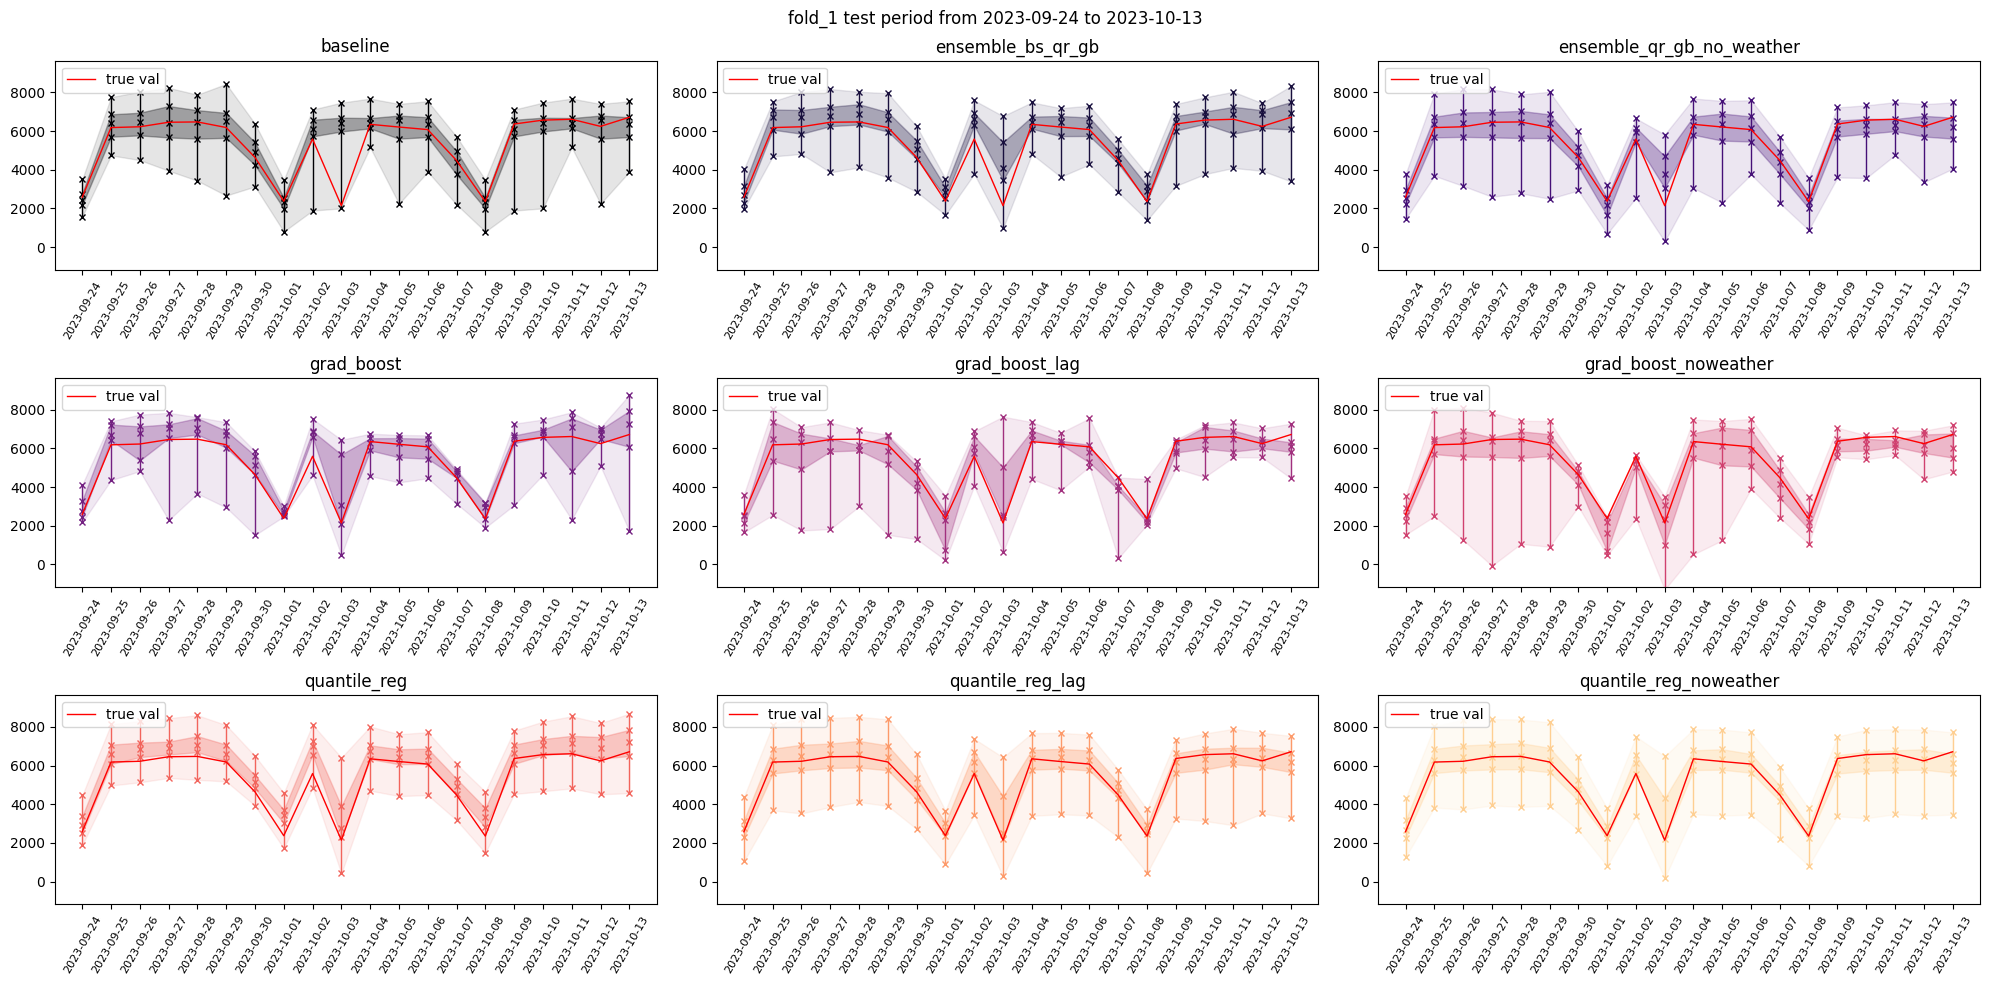

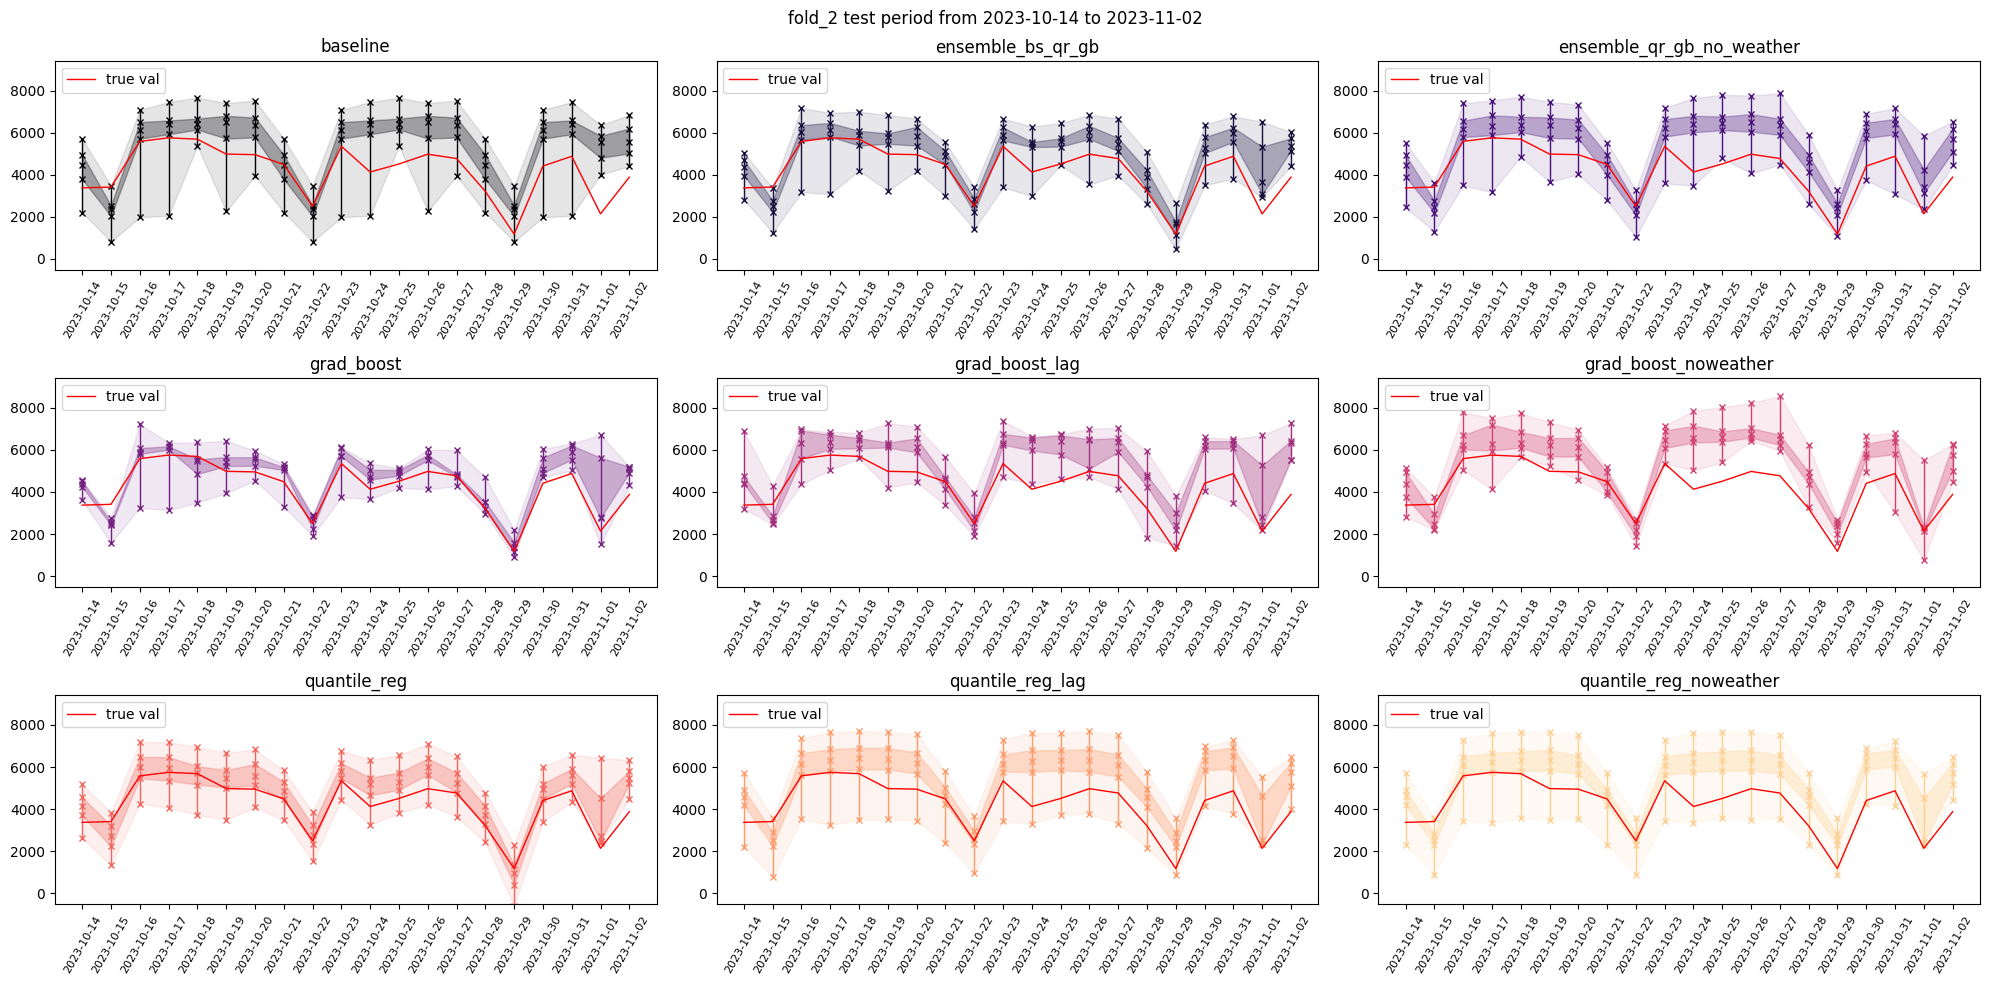

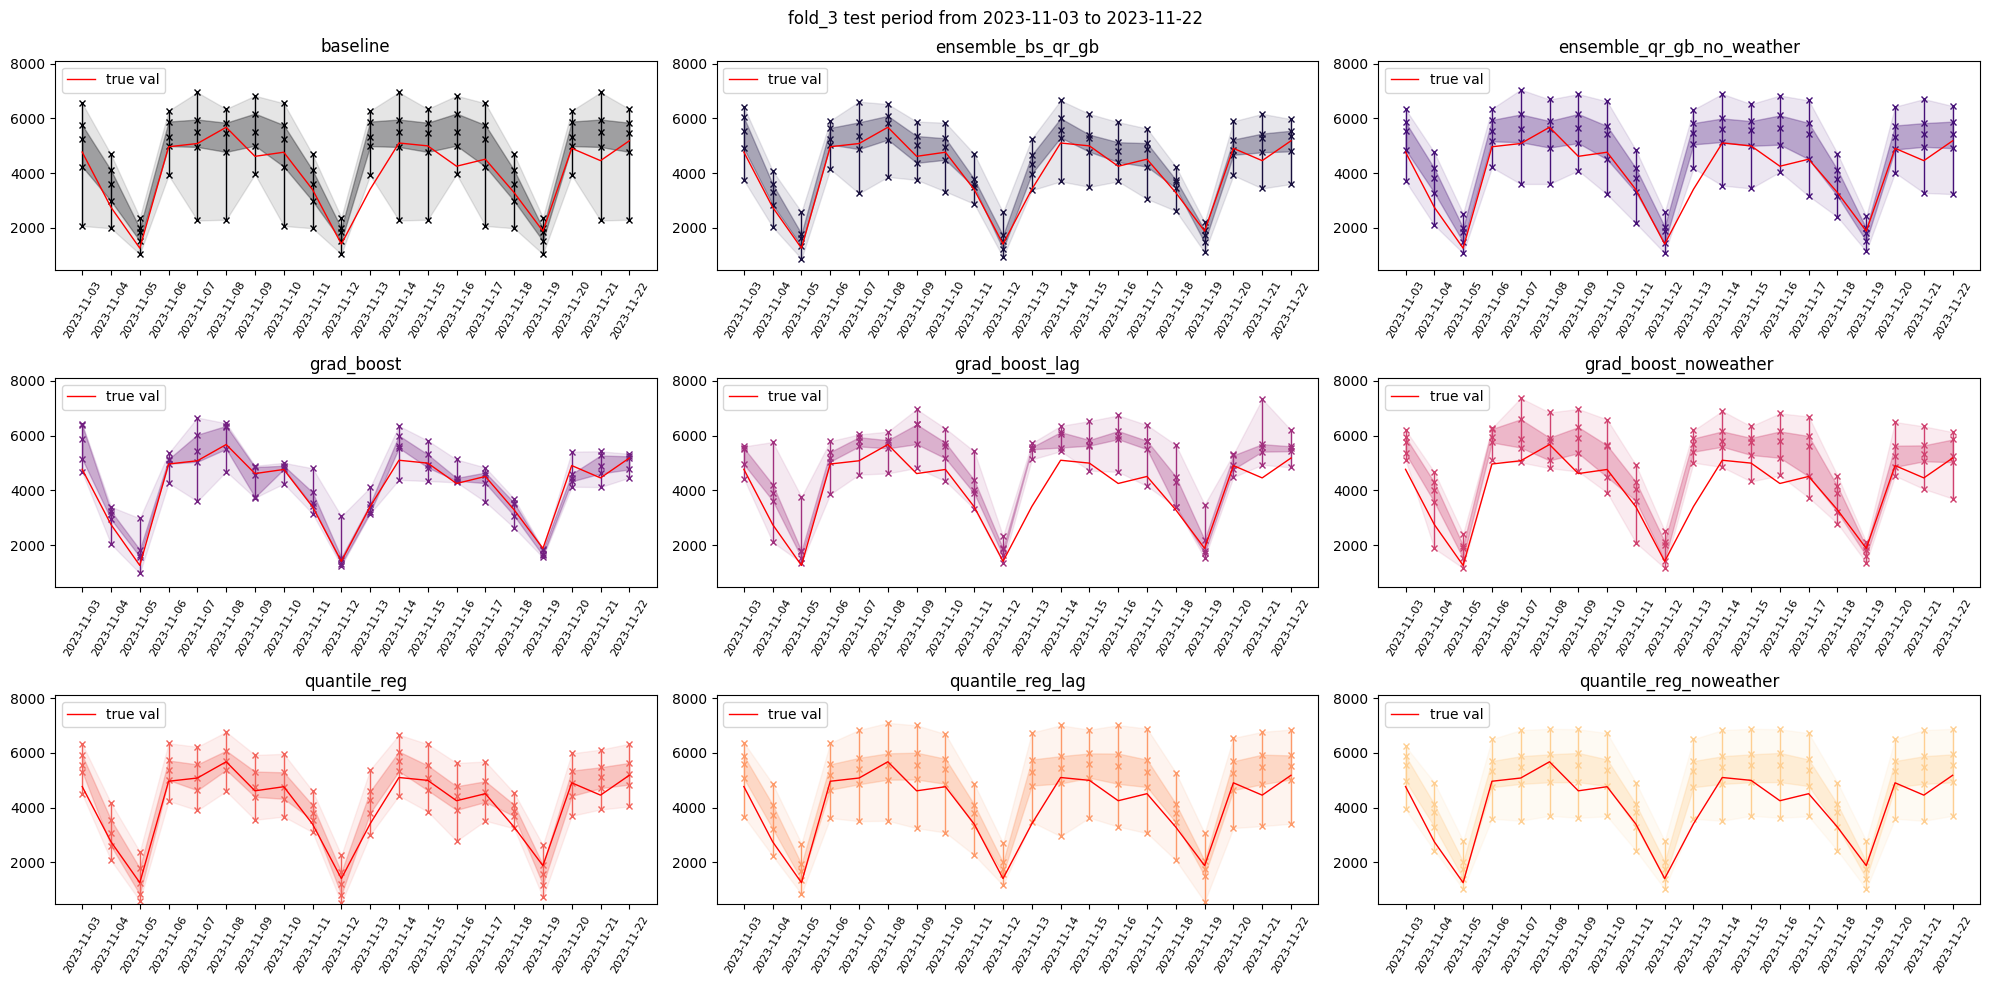

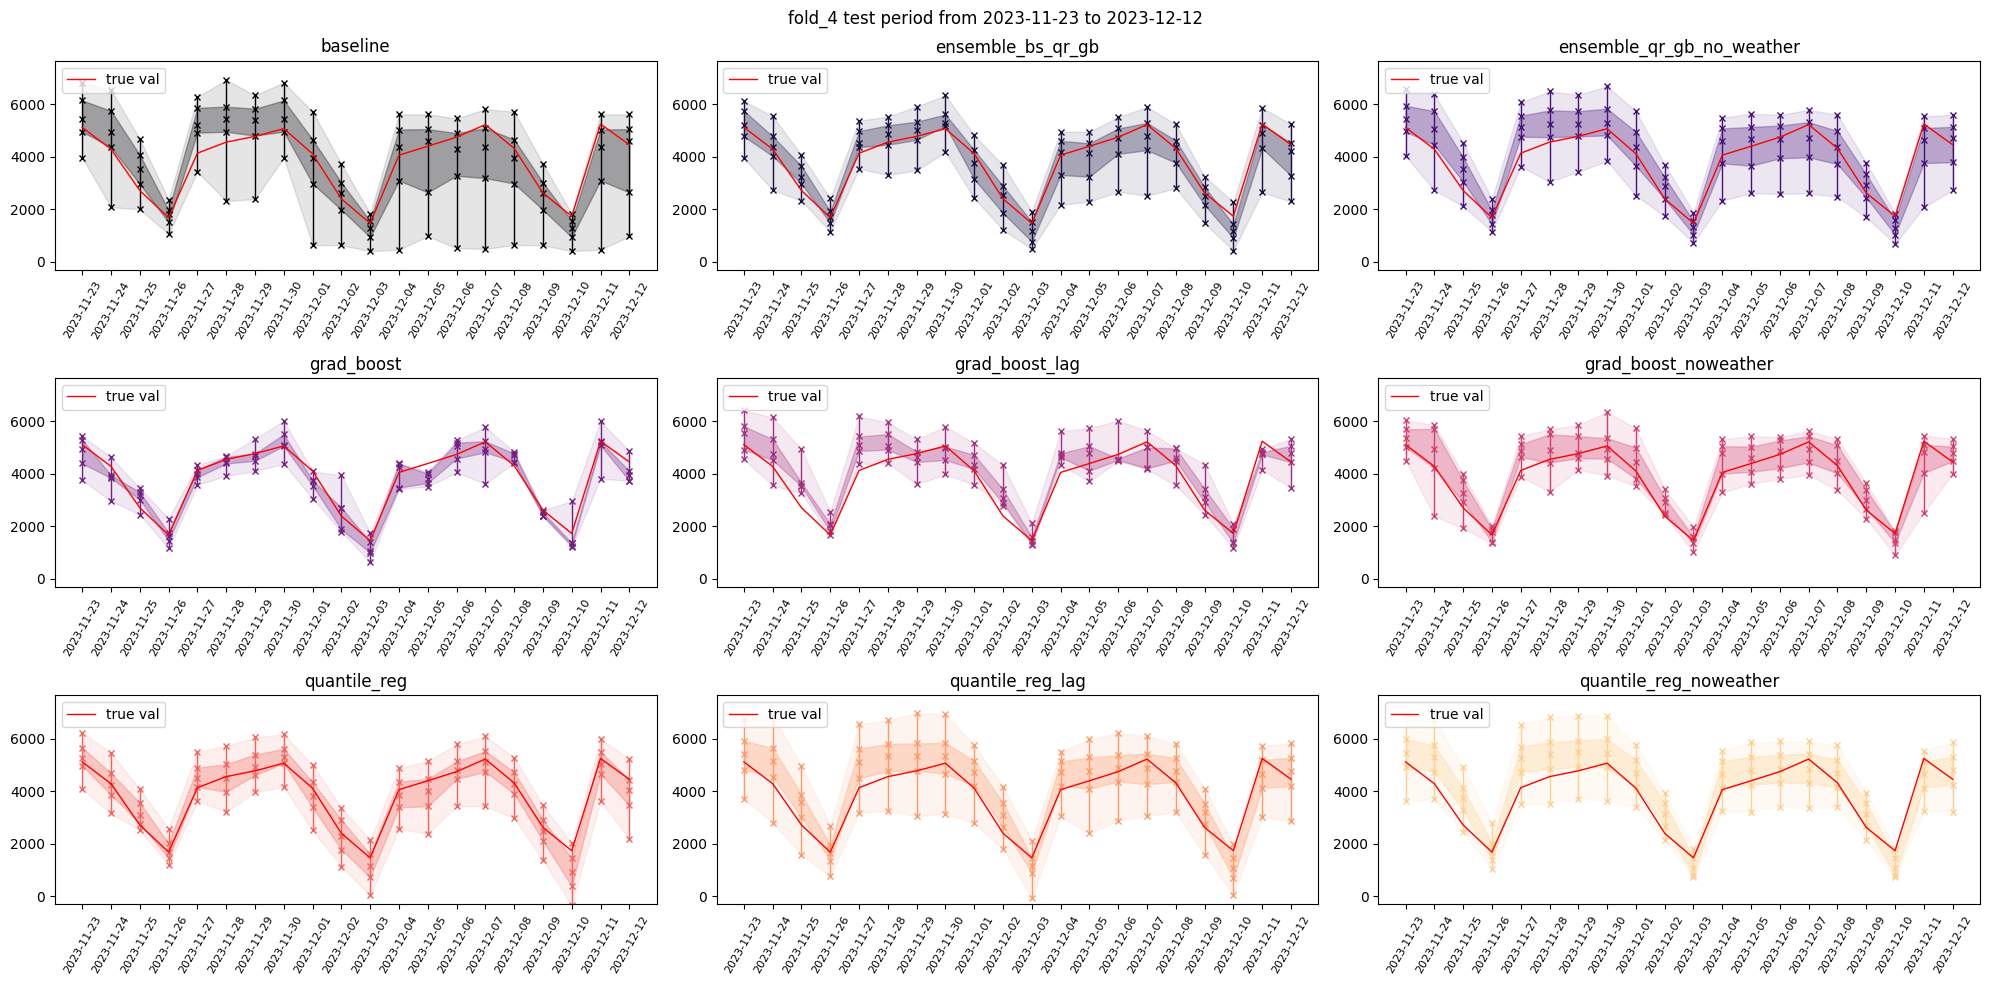

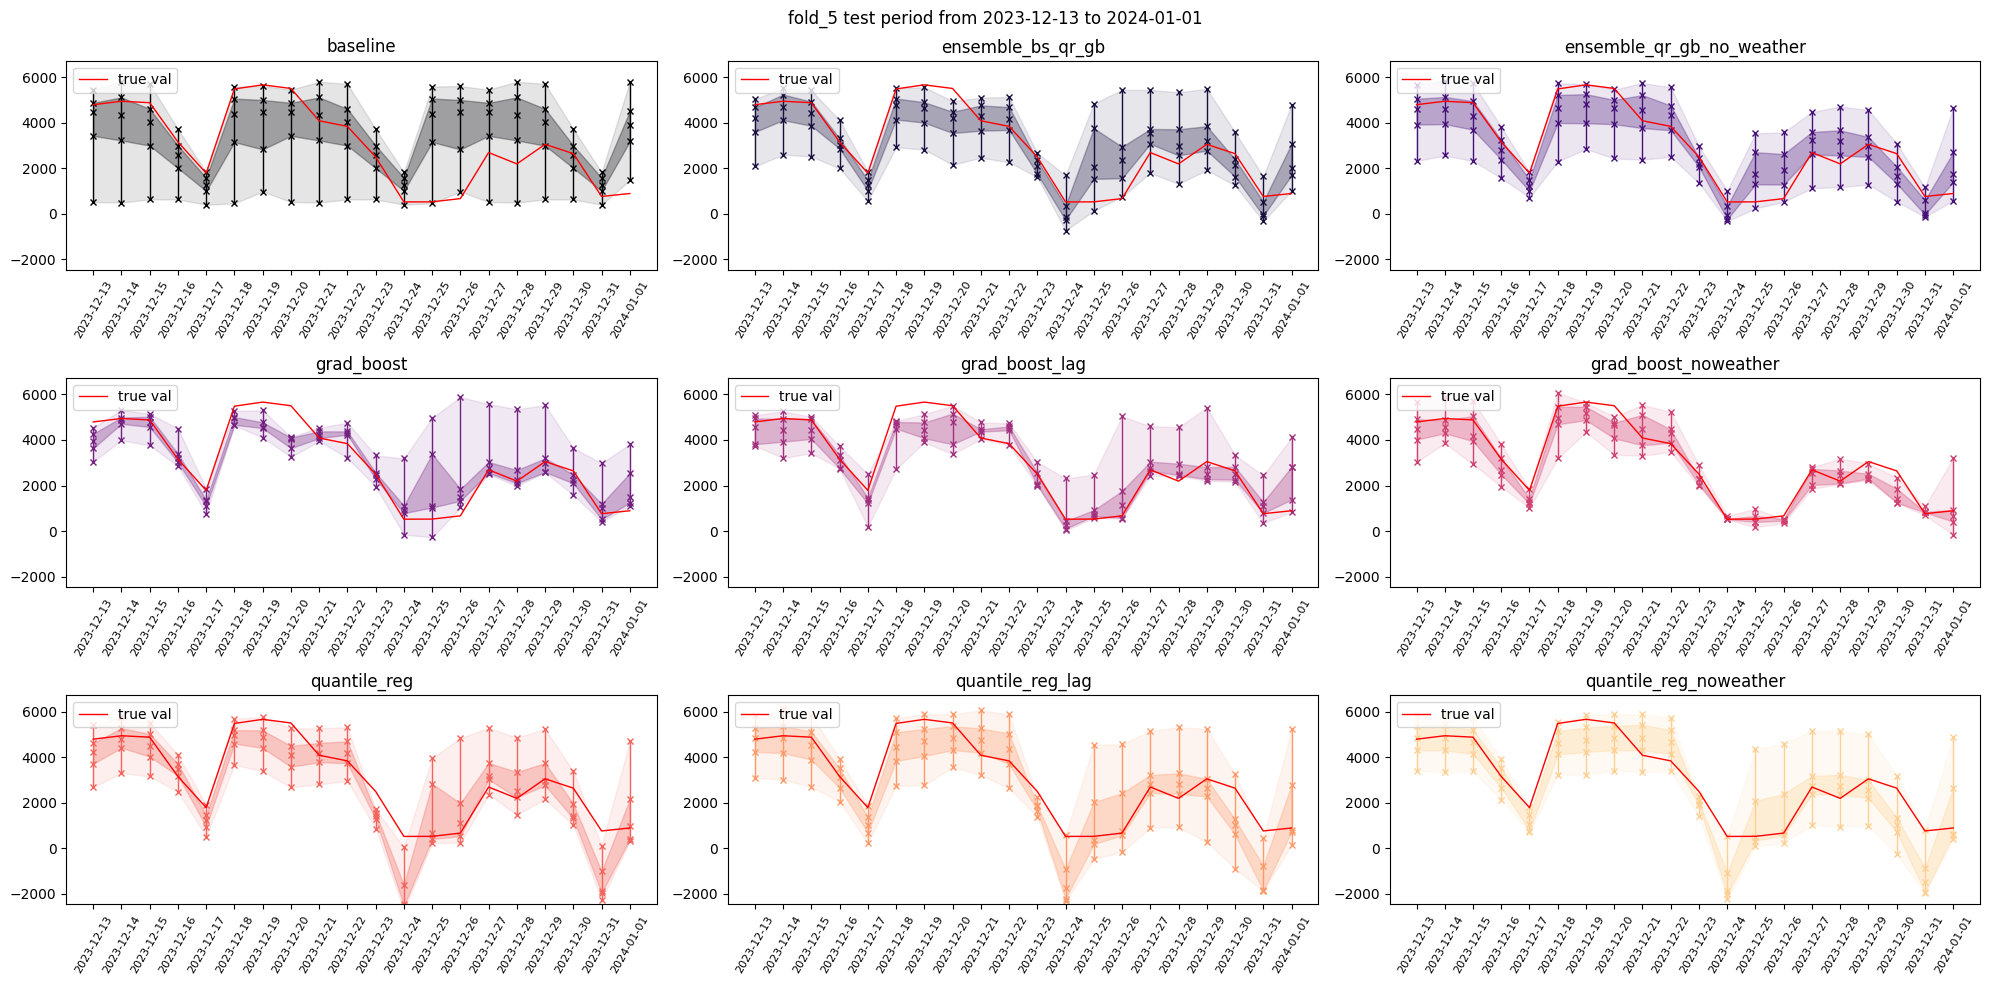

In [61]:
# read pickle file of all_results dict
with open(f'./plots/{fname_time}_all_results.pkl', 'rb') as f:
    all_results = pickle.load(f)

# create ensemble of all preds for each fold
for fold_idx in range(n_fold):

    fold_results = all_results[f'fold_{fold_idx + 1}']
    pred_baseline = fold_results['baseline']['predictions']

    pred_quant_reg = fold_results['quantile_reg']['predictions']
    pred_grad_boost = fold_results['grad_boost']['predictions']

    pred_quant_reg_noweather = fold_results['quantile_reg_noweather']['predictions']
    pred_grad_boost_noweather = fold_results['grad_boost_noweather']['predictions']

    pred_ensemble1 = np.average([pred_baseline, pred_quant_reg, pred_grad_boost], axis=0)
    pred_ensemble2 = np.average([pred_quant_reg, pred_grad_boost], axis=0)
    pred_ensemble3 = np.average([pred_quant_reg_noweather, pred_grad_boost_noweather, pred_baseline], axis=0)

    all_results[f'fold_{fold_idx + 1}']['ensemble_bs_qr_gb'] = {}
    all_results[f'fold_{fold_idx + 1}']['ensemble_bs_qr_gb']['predictions'] = pred_ensemble1

    # all_results[f'fold_{fold_idx + 1}']['ensemble2_w_qr_gb'] = {}
    # all_results[f'fold_{fold_idx + 1}']['ensemble2_w_qr_gb']['predictions'] = pred_ensemble2

    all_results[f'fold_{fold_idx + 1}']['ensemble_qr_gb_no_weather'] = {}
    all_results[f'fold_{fold_idx + 1}']['ensemble_qr_gb_no_weather']['predictions'] = pred_ensemble3

# Initialize lists to store metrics, quantile scores, and mean quantile scores
# model_names = ['baseline', 'ensemble_all', 'ensemble_qr_gb',
#                'quantile_reg', 'quantile_reg_noweather', 'quantile_reg_lag',
#                'grad_boost', 'grad_boost_noweather', 'grad_boost_lag']

model_names = [i for i in all_results['fold_1'].keys() if i != 'true_values']
model_names = sorted(model_names)
print(f"model names: {model_names}")
fold_names = [f'fold_{fold_idx + 1}' for fold_idx in range(n_fold)]

colors = plt.cm.magma(np.linspace(0, 0.9, len(model_names))) 
# stop at 0.9 since 1 is light yellow and cant be seen on white background

metrics_data = {'Model': [], 'Fold': [], 'MSE': [], 'MAE': [], 'MAPE': [], 'Mean_Quantile_Score': [], 
                'q_score_0.025': [], 'q_score_0.25': [], 'q_score_0.5': [], 
                'q_score_0.75': [], 'q_score_0.975': []}

# Loop through each fold and each model
for fold_name in fold_names:
    
    fold_results = all_results[fold_name]
    df_true = fold_results['true_values']
    y_true = df_true.values
    
    max_vals = [np.max(fold_results[model_name]['predictions']) for model_name in model_names]
    min_vals = [np.min(fold_results[model_name]['predictions']) for model_name in model_names]
    max_val = np.max(max_vals)*1.1
    min_val = np.min(min_vals)*0.9

    # start plotting
    fig, (axes) = plt.subplots(3, 3, figsize=(20,10))
    axes = axes.flatten()

    for model_idx, model_name in enumerate(model_names):

        predictions = fold_results[model_name]['predictions']
        predictions = fix_quantile_crossing_np(predictions)

        # Plot
        ax = axes[model_idx]

        x = fold_results['true_values'].index.date
        ax.plot(x, predictions, ls="", marker='x', ms=5, color=colors[model_idx])
        ax.plot((x,x), (predictions[:,0], predictions[:,-1]), lw=1, color=colors[model_idx]) 
        ax.fill_between(x, predictions[:,0], predictions[:,-1], alpha=0.1, color=colors[model_idx])
        ax.fill_between(x, predictions[:,1], predictions[:,-2], alpha=0.3, color=colors[model_idx])
        
        ax.plot(x, y_true, lw=1, c='red', label='true val')
        ax.set_xticks(x, x, rotation=60, fontsize=8)
        ax.set_ylim(min_val, max_val)
        ax.legend(loc='upper left')
        ax.set_title(model_name)

        # Calculate metrics
        mse = np.mean((predictions[:, 2] - y_true)**2)
        mae = np.mean(np.abs(predictions[:, 2] - y_true))
        mape = np.mean(np.abs((predictions[:, 2] - y_true) / y_true))

        quantile_scores = []
        for alpha_idx, alpha in enumerate(quantiles_arr):
            quantile_score = mean_pinball_loss(y_true, predictions[:, alpha_idx], alpha=alpha)
            quantile_scores.append(quantile_score)
        mean_quantile_score = np.mean(quantile_scores)

        # Save metrics to the dictionary
        metrics_data['Model'].append(model_name)
        metrics_data['Fold'].append(fold_name)
        metrics_data['MSE'].append(mse)
        metrics_data['MAE'].append(mae)
        metrics_data['MAPE'].append(mape)
        metrics_data['q_score_0.025'].append(quantile_scores[0])
        metrics_data['q_score_0.25'].append(quantile_scores[1])
        metrics_data['q_score_0.5'].append(quantile_scores[2])
        metrics_data['q_score_0.75'].append(quantile_scores[3])
        metrics_data['q_score_0.975'].append(quantile_scores[4])
        metrics_data['Mean_Quantile_Score'].append(mean_quantile_score)

    plt.suptitle(f'{fold_name} test period from {df_true.index[0].date()} to {df_true.index[-1].date()}')
    plt.tight_layout()
    plt.show()
    fig.savefig(f'./plots/{fname_time}_rolling_window_{fold_name}.png')

#### metrics

model names: ['baseline', 'ensemble_all', 'ensemble_qr_gb', 'grad_boost', 'grad_boost_lag', 'grad_boost_noweather', 'quantile_reg', 'quantile_reg_lag', 'quantile_reg_noweather']


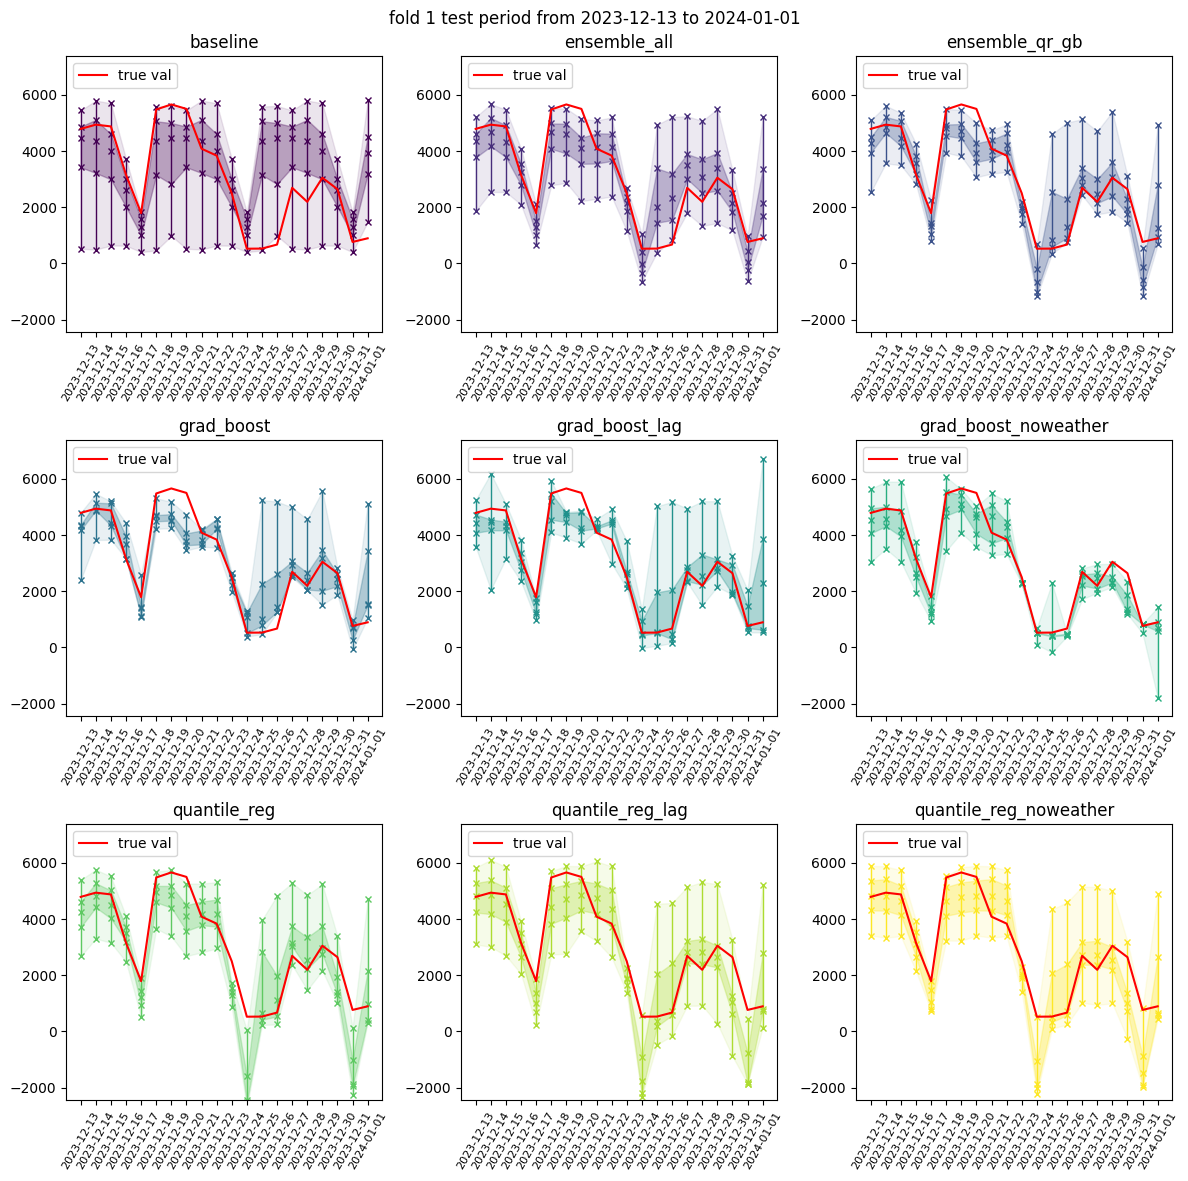

,Model,Fold,Mean_Quantile_Score,q_score_0.025,q_score_0.25,q_score_0.5,q_score_0.75,q_score_0.975
0,baseline,fold_1,148.984650,60.760219,272.906250,204.587500,168.546875,38.122406
9,baseline,fold_2,390.019113,200.778938,625.959375,648.875000,417.828125,56.654125
18,baseline,fold_3,171.524119,65.611250,200.200000,297.475000,253.606250,40.728094
27,baseline,fold_4,152.868738,60.889813,250.984375,229.087500,190.962500,32.419500
36,baseline,fold_5,340.574856,104.876281,571.059375,590.737500,387.062500,49.138625
1,ensemble_bs_qr_gb,fold_1,133.258215,48.905829,140.802155,223.060849,214.367935,39.154308
10,ensemble_bs_qr_gb,fold_2,235.325190,92.921551,346.959868,396.146842,295.452849,45.144838
19,ensemble_bs_qr_gb,fold_3,101.712589,24.829862,105.788649,188.624987,158.663518,30.655926
28,ensemble_bs_qr_gb,fold_4,87.568715,36.345859,156.371542,119.844887,103.096501,22.184788
37,ensemble_bs_qr_gb,fold_5,210.309348,47.015107,296.105614,347.748926,291.918836,68.758259


Model
grad_boost                   129.734795
quantile_reg                 148.735066
ensemble_bs_qr_gb            153.634811
ensemble_qr_gb_no_weather    186.862291
quantile_reg_noweather       187.482450
quantile_reg_lag             189.292186
grad_boost_noweather         190.005049
grad_boost_lag               203.417284
baseline                     240.794295
Name: mean, dtype: float64

In [62]:
# Create a DataFrame from the metrics data
metrics_df = pd.DataFrame(metrics_data)
display(metrics_df.sort_values(by=['Model', 'Fold']).drop(columns=['MSE', 'MAE', 'MAPE']))

# sort by model and then fold
# print(metrics_df.sort_values(by=['Model', 'Fold'])[['Model', 'Fold', 'MAE', 'Mean_Quantile_Score']])

# create pivot table with fold as index, model as columns and mean quantile score as values
metrics_df_pivot = pd.pivot_table(metrics_df, index='Fold', columns='Model', values='Mean_Quantile_Score')
# create last row = sum of all folds
metrics_df_pivot.loc['mean'] = metrics_df_pivot.mean()
# highlight min value in each row
metrics_df_pivot.style.highlight_min(axis=1)

# # Save the DataFrame to a CSV file or use it as needed
# metrics_df.to_csv('model_metrics.csv', index=False)

# rank all models by their total mean quantile score for all quantiles
metrics_df_pivot.loc['mean'].sort_values()

In [55]:
# pred_names = ['baseline', 'quantile reg', 'gradient boosting']
# colors = ['orange', 'blue', 'green']
# markers = ['o', 'x', 's']
# x = horizon_dates

# for pred_idx, pred in enumerate(preds):

#     ax = axes[pred_idx]
#     ax.plot(x, pred, ls="", marker=markers[pred_idx], ms=5, color=colors[pred_idx])
#     # plot vertical range line
#     ax.plot((x,x), (pred[:,0], pred[:,-1]), lw=1, color=colors[pred_idx]) 
#     # plot fill between max and min quantile
#     ax.fill_between(x, pred[:,0], pred[:,-1], alpha=0.1, color=colors[pred_idx])
#     # plot fille between 25 and 75 quantile
#     ax.fill_between(x, pred[:,1], pred[:,-2], alpha=0.3, color=colors[pred_idx], label=f"{pred_names[pred_idx]}")
    
#     ax.plot(x, df_test['bike_count'], c='red', label='true val')
#     ax.set_xticks(x, x, rotation=45)
#     ax.set_ylim(min_val, max_val)
#     ax.legend(loc='upper left')

#     # = = = = = = = = = = = = = = = = = 
#     # print metrics: MSE, MAE, quantile score
#     print('- '*15)
#     print(f">> {pred_names[pred_idx]} metrics")

#     # MSE
#     mse = np.mean((pred[:,2] - df_test['bike_count'].values)**2)
#     print(f"MSE: {mse:.2f}")
#     # MAE
#     mae = np.mean(np.abs(pred[:,2] - df_test['bike_count'].values))
#     print(f"MAE: {mae:.2f}")
#     # quantile score using sklearn mean pinball loss
#     from sklearn.metrics import mean_pinball_loss
#     for alph_idx, alpha in enumerate(quantiles_arr):
#         quantile_score = mean_pinball_loss(df_test['bike_count'].values, pred[:,alph_idx], alpha=alpha)
#         print(f"quantile score {alpha:.3f}: {quantile_score:.2f}")

# plt.tight_layout()
# plt.show()

### MSTL

c:\Users\ytl_c\miniconda3\Lib\site-packages\statsmodels\tsa\stl\mstl.py:217: UserWarning: A period(s) is larger than half the length of time series. Removing these period(s).
  warnings.warn(


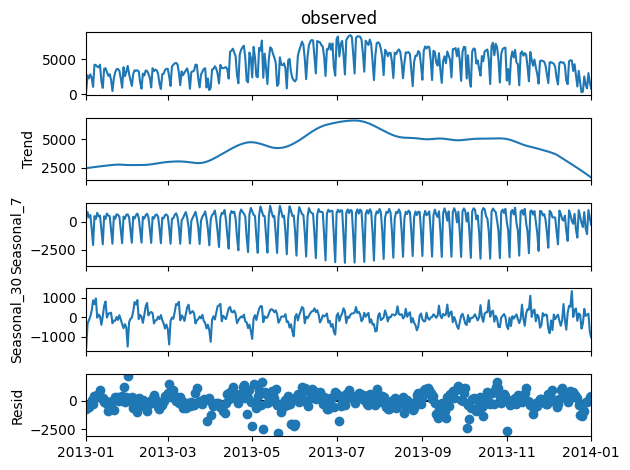

In [ ]:
# take smaller subset of data based on start and end timestamp in date column
# df_small = df.iloc[0:1000]
start   = '2013-01-01'
end     = '2014-01-01'
df_small = df.loc[(df['timestamp_CET'] >= start) & (df['timestamp_CET'] <= end)]

# do MSTL on data
stl = MSTL(df_small['bike_count'], periods=[7, 30, 365])
res = stl.fit()
fig = res.plot()
plt.show()

### FFT

In [ ]:
# import math
# from cmath import phase
# from scipy import fft
# from scipy import signal as sig
# from sklearn.linear_model import LinearRegression

In [ ]:
# # take smaller subset of data based on start and end timestamp in date column
# start   = '2013-01-01'
# end     = '2014-01-01'
# df_small = df.loc[(df['date'] >= start) & (df['date'] <= end)]

# # do fft
# y = (df_small['bike_count'] - df_small['bike_count'].mean()).values
# yf = fft.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*365), len(y)//2)

# # get peaks of frequency spectrum
# from scipy.signal import find_peaks
# peaks, peak_prop = find_peaks(2.0/len(y) * np.abs(yf[:len(y)//2]), height=400, threshold=100, prominence=300)
# # print real frequencies of peaks in terms of days in original data
# print(np.round(1/xf[peaks]/365, 2))
# # print(peak_prop)

# fig, ax = plt.subplots(figsize=(12,4))
# ax.plot(xf, 2.0/len(y) * np.abs(yf[:len(y)//2]))
# ax.plot(xf[peaks], 2.0/len(y) * np.abs(yf[peaks]), "x")
# plt.show()

# # # reconstruct signal from peaks
# # yf2 = np.zeros(len(yf), dtype=complex)
# # for i in peaks:
# #     yf2[i] = yf[i]
# # y2 = fft.ifft(yf2)

# # # plot reconstructed signal
# # fig, ax = plt.subplots(figsize=(12,4))
# # ax.plot(df_small['date'], y2.real+df_small['bike_count'].mean())
# # # ax.plot(df_small['date'], df_small['bike_count'])
# # plt.show()

In [ ]:
# def add_trend_term(pdf):
#     pdf["trend"] = pdf.apply(lambda row: row.name + 1, axis=1)
#     return pdf

# def add_fourier_seasonality_term(pdf, column_name, period_min, period_max):
#     # Performs fourier transformation
#     fft_output = fft.fft(pdf[column_name].to_numpy())
#     amplitude = np.abs(fft_output)
#     freq = fft.fftfreq(len(pdf[column_name].to_numpy()))

#     mask = freq >= 0
#     freq = freq[mask]
#     amplitude = amplitude[mask]

#     # determine peaks
#     peaks = sig.find_peaks(amplitude[freq >= 0])[0]
#     peak_freq = freq[peaks]
#     peak_amplitude = amplitude[peaks]

#     # Create dataframe containing necessary parameters
#     fourier_output = pd.DataFrame()
#     fourier_output["index"] = peaks
#     fourier_output["freq"] = peak_freq
#     fourier_output["amplitude"] = peak_amplitude
#     fourier_output["period"] = 1 / peak_freq
#     fourier_output["fft"] = fft_output[peaks]
#     fourier_output["amplitude"] = fourier_output.fft.apply(lambda z: np.abs(z))
#     fourier_output["phase"] = fourier_output.fft.apply(lambda z: phase(z))

#     N = len(pdf.index)
#     fourier_output["amplitude"] = fourier_output["amplitude"] / N

#     fourier_output = fourier_output.sort_values("amplitude", ascending=False)
#     fourier_output = fourier_output[fourier_output["period"] >= period_min]
#     fourier_output = fourier_output[fourier_output["period"] <= period_max]

#     # Turn our dataframe into a dictionary for easy lookup
#     fourier_output_dict = fourier_output.to_dict("index")
#     pdf_temp = pdf[["trend"]].copy()

#     lst_periods = fourier_output["period"].to_list()
#     lst_periods = [int(round(val, 0)) for val in lst_periods]

#     for key in fourier_output_dict.keys():
#         a = fourier_output_dict[key]["amplitude"]
#         w = 2 * math.pi * fourier_output_dict[key]["freq"]
#         p = fourier_output_dict[key]["phase"]
#         pdf_temp[key] = pdf_temp["trend"].apply(
#                         lambda t: a * math.cos(w * t + p))

#     pdf_temp["FT_All"] = 0
#     for column in list(fourier_output.index):
#         pdf_temp["FT_All"] = pdf_temp["FT_All"] + pdf_temp[column]

#     pdf["seasonality"] = pdf_temp["FT_All"].astype(float)
#     pdf["seasonality"] = pdf["seasonality"].round(4)

#     predictors = ["trend", "seasonality"]
#     X = pdf[predictors]
#     y = pdf["bike_count"]

#     X_predict = pdf[predictors]

#     # Initialise and fit model
#     lm = LinearRegression()
#     model = lm.fit(X, y)

#     # Forecast baseline for entire dataset
#     pdf["baseline"] = model.predict(X_predict)
#     pdf["baseline"] = pdf["baseline"].round(4)
#     return (fourier_output, pdf)


# def create_plots(pdf, period_min, period_max):
#     pdf = pdf.reset_index()
#     pdf = add_trend_term(pdf=pdf)

#     (fourier_output, pdf) = add_fourier_seasonality_term(
#         pdf,
#         column_name="bike_count",
#         period_min=period_min,
#         period_max=period_max
#     )

#     pdf["date"] = pd.to_datetime(pdf["date"], format="%Y-%m-%d")
#     pdf = pdf.set_index("date")

#     fig, axs = plt.subplots(ncols=1, figsize=(30, 5))
#     sns.lineplot(data=pdf, x="date", y="bike_count", 
#                  label="bike_count", color="grey")

#     sns.lineplot(x="date", y="baseline", data=pdf, ax=axs, 
#                  label="baseline", color="black")
#     axs.legend()
#     plt.show()

In [ ]:
# create_plots(pdf=df_small, period_min=7, period_max=365)

### Quantile Regression

In [ ]:
# take smaller subset of data based on start and end timestamp in date column
# df_small = df.iloc[0:1000]
start   = '2013-01-01'
end     = '2019-01-01'
df_small = df.loc[(df['timestamp_CET'] >= start) & (df['timestamp_CET'] <= end)]

n_total = len(df_small)
n_train = int(n_total * 0.9)

df_dummy = data_prepro.create_dummy_df(df_small, holiday_method='separate')

# mean_val = df_dummy['bike_count'].mean()
# df_dummy['bike_count'] = df_dummy['bike_count'] - mean_val

X_train_dummy = df_dummy.drop(columns=['bike_count', 'timestamp_CET']).iloc[:n_train]
y_train_dummy = df_dummy['bike_count'].iloc[:n_train]

X_test_dummy = df_dummy.drop(columns=['bike_count', 'timestamp_CET']).iloc[n_train:]
y_test_dummy = df_dummy['bike_count'].iloc[n_train:]

In [ ]:
quantiles_arr = [0.025, 0.25, 0.5, 0.75, 0.975]

print('- '*15)  
print(f'> start training quantile regression models ...')

all_models_quant_reg = {}
for alpha in quantiles_arr:

    print(f'>> alpha = {alpha:.3f} ...')
    quantile_regressor = QuantileRegressor(quantile=alpha, alpha=0, solver='highs')
    all_models_quant_reg[f"q {alpha:.3f}"] = quantile_regressor.fit(X_train_dummy, y_train_dummy)

    # print(quantile_regressor.intercept_)
    # df_coef_w_names = pd.DataFrame(quantile_regressor.coef_, index=quantile_regressor.feature_names_in_)
    # print(df_coef_w_names.to_string())

- - - - - - - - - - - - - - - 
> start training quantile regression models ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...


In [ ]:
# # np.set_printoptions(suppress=True)
# # np.round(all_models_quant_reg['q 0.500'].coef_, 2)

# # create df with cols ... 
#     # keys = colnames from X_train
#     # values = coef from quantile regression

# df_coef_w_names = pd.DataFrame()
# for key in all_models_quant_reg.keys():
#     df_coef_w_names[key] = all_models_quant_reg[key].coef_

# df_coef_w_names.index = X_train_dummy.columns
# round(df_coef_w_names, 2)

In [ ]:
# in sample fit
y_pred_in = pd.DataFrame()
for alpha in quantiles_arr:
    y_pred_in[f"q {alpha:.3f}"] = all_models_quant_reg[f"q {alpha:.3f}"].predict(X_train_dummy)

# out of sample fit
y_pred_out = pd.DataFrame()
for alpha in quantiles_arr:
    y_pred_out[f"q {alpha:.3f}"] = all_models_quant_reg[f"q {alpha:.3f}"].predict(X_test_dummy)

# # plot predictions
fig, axs = plt.subplots(ncols=1, figsize=(15, 5))
    
plt.plot(y_train_dummy.index, y_train_dummy, label='train', alpha=0.7)
plt.plot(y_train_dummy.index, y_pred_in['q 0.500'], lw=1, ls='--', label='in sample', color='red')

# # plt.plot(y_test_dummy.index, y_test_dummy, label='test', alpha=0.7)
# # plt.plot(y_test_dummy.index, y_pred_out['q 0.500'], lw=1, ls='--', label='out of sample', color='red')
    
# plt.legend()
# plt.show()

plt.figure(figsize=(24, 8))
plt.title('quant reg model')

df_pred = data_prepro.fix_quantile_crossing(y_pred_out)

colors = ['', 'lightblue', 'mediumblue', 'black', 'mediumblue', 'lightblue']
for idx, quantile in enumerate(df_pred.columns):
    if idx == 0:
        continue # skip first col
    y_pred = df_pred[quantile]
    plt.plot(y_test_dummy.index, y_pred, label=f'{quantile}', lw=1, alpha=1, color=colors[idx])

plt.fill_between(y_test_dummy.index, df_pred['q 0.025'], df_pred['q 0.975'], color='lightblue', alpha=0.1)
plt.fill_between(y_test_dummy.index, df_pred['q 0.250'], df_pred['q 0.750'], color='mediumblue', alpha=0.1)

plt.plot(y_test_dummy.index, y_test_dummy, label='test', ls='--', color='red')
# plot horiz line at y=0
plt.axhline(y=0, color='black', lw=1, ls='--')

plt.ylim(-2_000, 9_000)
plt.legend()
plt.show()

NameError: name 'pd' is not defined

In [ ]:
# # plot each col in df_small other than cols starting with 'month', 'weekday', 'is_holiday'
# # in separate subplots

# df_plot = df_small.copy()
# df_plot.drop(columns=['timestamp_CET'], inplace=True)
# # drop cols starting with 'month', 'weekday', 'is_holiday'
# df_plot.drop(columns=[col for col in df_plot.columns if col.startswith('month') or col.startswith('weekday') or col.startswith('is_holiday')], inplace=True)

# fig, axs = plt.subplots(len(df_plot.columns), 1, figsize=(15, 30))
# axs = axs.flatten()

# for i, col in enumerate(df_plot.columns):
#     axs[i].plot(df_small.index, df_small[col])
#     axs[i].set_title(col)

#     # highlight the period around 2015-11-01 using a vertical line
#     axs[i].axvline(x=pd.to_datetime('2018-09-01'), color='red', alpha=0.5)

# plt.tight_layout()
# plt.show()

### Gradient Boosting

In [ ]:
# # Grid Search for Gradient Boosting Regressor
# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
# from sklearn.ensemble import GradientBoostingRegressor

# # take smaller subset of data based on start and end timestamp in date column
# # df_small = df.iloc[0:1000]
# start   = '2013-01-01'
# end     = '2017-01-01'
# df_small = df.loc[(df['timestamp_CET'] >= start) & (df['timestamp_CET'] <= end)]

# n_total = len(df_small)
# n_train = int(n_total * 0.9)

# df_features = data_prepro.create_features_df(df_small, holiday_method='separate')
# # print(df_features.columns)

# X_train_fturs = df_features.drop(columns=['bike_count', 'timestamp_CET']).iloc[:n_train]
# y_train_fturs = df_features['bike_count'].iloc[:n_train]

# X_test_fturs = df_features.drop(columns=['bike_count', 'timestamp_CET']).iloc[n_train:]
# y_test_fturs = df_features['bike_count'].iloc[n_train:]

# print(X_train_fturs.shape)

# # = = = = = = 
# # sklearn
# # = = = = = = 

# quantiles_arr = [0.025, 0.25, 0.5, 0.75, 0.975]

# for alpha in quantiles_arr:

#     print('= '*15)
#     print(f'start alpha = {alpha}')
#     print('= '*15)

#     cv_split = TimeSeriesSplit(n_splits=3, test_size=100)
#     # model = GradientBoostingRegressor(loss="squared_error")
#     model = GradientBoostingRegressor(loss="quantile", alpha=alpha)
#     parameters = {
#         "max_depth": [5, 7, 10],
#         "learning_rate": [0.2, 0.5],
#         "n_estimators": [100, 200, 400],
#         'subsample': [0.5, 0.7, 0.9],
#         'min_samples_leaf': [3, 5, 10]
#     }

#     # HistGradientBoostingRegressor uses different parameters
#     # ie n_estimators is not an input argument

#     grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters, n_jobs=1, verbose=4)
#     grid_search.fit(X_train_fturs, y_train_fturs)
#     # score closer to 1 is better !!!

#     # Accessing the best parameters
#     best_params = grid_search.best_params_
#     print(f"Best Parameters: {best_params}")

#     print(' ')

# # = = = = = = 
# # loss = squared error
# # Best Parameters: {'learning_rate': 0.3, 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 200, 'subsample': 0.9}
# # - - - - - -
# # loss = quantile, 2013 -> 2017 (separate holidays)
# # q = 0.025
# # > Best Parameters: {'learning_rate': 0.5, 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 400, 'subsample': 0.5}
# # q = 0.250
# # > Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'min_samples_leaf': 3, 'n_estimators': 400, 'subsample': 0.9}
# # q = 0.500
# # > Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 400, 'subsample': 0.9}
# # q = 0.750
# # > Best Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 400, 'subsample': 0.9}
# # q = 0.975
# # > Best Parameters: {'learning_rate': 0.5, 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 400, 'subsample': 0.7}
# # = = = = = = 

In [ ]:
# take smaller subset of data based on start and end timestamp in date column
# df_small = df.iloc[0:1000]
start   = '2013-01-01'
end     = '2019-01-01'
df_small = df.loc[(df['timestamp_CET'] >= start) & (df['timestamp_CET'] <= end)]

df_features = data_prepro.create_features_df(df_small, holiday_method='separate')
# print(df_features.columns)

X_train_fturs = df_features.drop(columns=['bike_count', 'timestamp_CET']).iloc[:n_train]
y_train_fturs = df_features['bike_count'].iloc[:n_train]

X_test_fturs = df_features.drop(columns=['bike_count', 'timestamp_CET']).iloc[n_train:]
y_test_fturs = df_features['bike_count'].iloc[n_train:]


In [ ]:
quantiles_arr = [0.025, 0.25, 0.5, 0.75, 0.975]

# - - - - - - - - - -
# gradient boosting with features
    
# quantile_params = {0.025: {'learning_rate': 0.4, 'max_depth': 10, 'min_samples_leaf': 7, 'n_estimators': 400, 'subsample': 0.9}, 
#                    0.250: {'learning_rate': 0.3, 'max_depth': 10, 'min_samples_leaf': 6, 'n_estimators': 250, 'subsample': 0.7},
#                    0.500: {'learning_rate': 0.3, 'max_depth': 5, 'min_samples_leaf': 6, 'n_estimators': 400, 'subsample': 0.8},
#                    0.750: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 7, 'n_estimators': 250, 'subsample': 0.7},
#                    0.975: {'learning_rate': 0.4, 'max_depth': 10, 'min_samples_leaf': 6, 'n_estimators': 400, 'subsample': 0.7}}

quantile_params = {0.025: {'learning_rate': 0.5, 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 400, 'subsample': 0.5},
                   0.250: {'learning_rate': 0.2, 'max_depth': 7, 'min_samples_leaf': 3, 'n_estimators': 400, 'subsample': 0.9},
                   0.500: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 400, 'subsample': 0.9},
                   0.750: {'learning_rate': 0.2, 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 400, 'subsample': 0.9},
                   0.975: {'learning_rate': 0.5, 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 400, 'subsample': 0.7}}

print('- '*15)  
print(f'> start training gradient boosting models ...')

# start counting time
start_time = time.time()

all_models_grad_boost = {}
for alpha in quantiles_arr:

    print(f'>> alpha = {alpha:.3f} ...')

    params = quantile_params[alpha]
    # pprint(params)

    # Use the QuantileRegressor for faster training on small to medium datasets n < 10_000
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **params)

    # Use the HistGradientBoostingRegressor for faster training on large datasets n > 10_000
    # gbr = HistGradientBoostingRegressor(loss='quantile', quantile=alpha, **params)

    all_models_grad_boost[f"q {alpha:.3f}"] = gbr.fit(X_train_fturs, y_train_fturs)

# print time taken
print(f"> time taken: {time.time() - start_time:.2f} seconds")

- - - - - - - - - - - - - - - 
> start training gradient boosting models ...
>> alpha = 0.025 ...
>> alpha = 0.250 ...
>> alpha = 0.500 ...
>> alpha = 0.750 ...
>> alpha = 0.975 ...
> time taken: 56.37 seconds


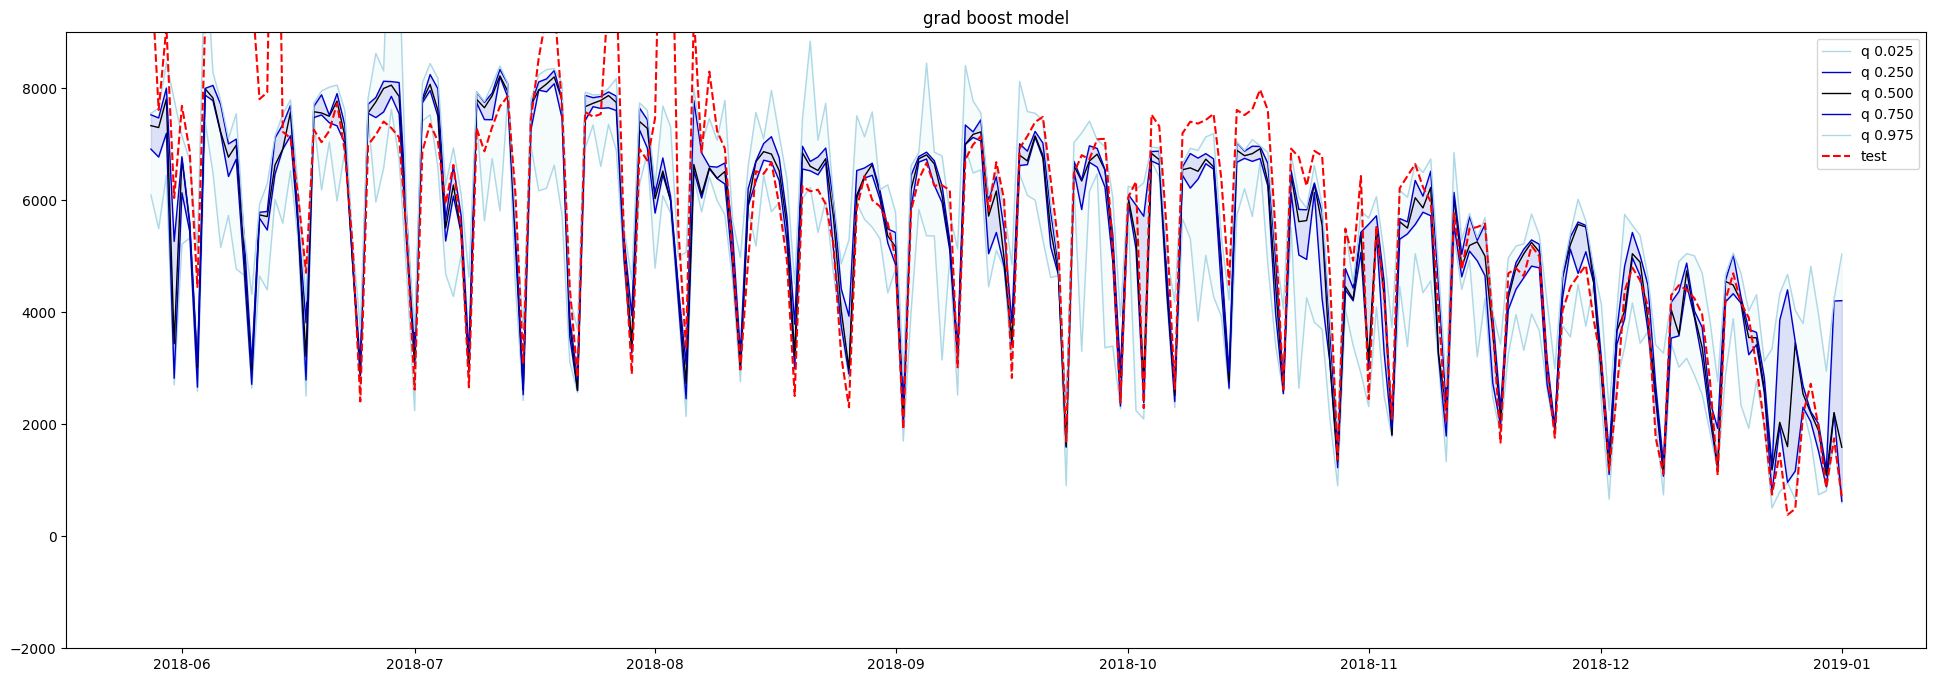

In [ ]:
# in sample fit
y_pred_in = pd.DataFrame()
for alpha in quantiles_arr:
    y_pred_in[f"q {alpha:.3f}"] = all_models_grad_boost[f"q {alpha:.3f}"].predict(X_train_fturs)

# out of sample fit
y_pred_out = pd.DataFrame()
for alpha in quantiles_arr:
    y_pred_out[f"q {alpha:.3f}"] = all_models_grad_boost[f"q {alpha:.3f}"].predict(X_test_fturs)

# # plot predictions
# fig, axs = plt.subplots(ncols=1, figsize=(15, 5))

# plt.plot(y_train_fturs.index, y_train_fturs, label='train', alpha=0.7)
# plt.plot(y_train_fturs.index, y_pred_in['q 0.500'], lw=1, ls='--', label='in sample', color='red')

# # plt.plot(y_test_fturs.index, y_test_fturs, label='test', alpha=0.7)
# # plt.plot(y_test_fturs.index, y_pred_out['q 0.500'], lw=1, ls='--', label='out of sample', color='red')

# plt.legend()
# plt.show()

plt.figure(figsize=(24, 8))
plt.title('grad boost model')

df_pred = data_prepro.fix_quantile_crossing(y_pred_out)

for quantile in df_pred.columns:

    y_pred = df_pred[quantile]
    quantile_float = float(quantile[2:])

    # Save predicted values based on quantile
    if '0.025' in quantile:
        y_pred_025 = y_pred
        col = 'lightblue'
    elif '0.25' in quantile:
        y_pred_25 = y_pred
        col = 'mediumblue'
    elif '0.5' in quantile:
        y_pred_50 = y_pred
        col = 'black'
    elif '0.75' in quantile:
        y_pred_75 = y_pred
        col = 'mediumblue'
    elif '0.975' in quantile:
        y_pred_975 = y_pred
        col = 'lightblue'
    
    # Plot the prediction line
    plt.plot(y_test_fturs.index, y_pred, label=f'{quantile}', lw=1, alpha=1, color=col)

plt.fill_between(y_test_fturs.index, y_pred_025, y_pred_975, color='lightblue', alpha=0.1)
plt.fill_between(y_test_fturs.index, y_pred_25, y_pred_75, color='mediumblue', alpha=0.1)
plt.plot(y_test_fturs.index, y_test_fturs, label='test', ls='--', color='red')

plt.ylim(-2_000, 9_000)
plt.legend()
plt.show()